# Examples for the AbsComopnent Class (v0.1)

In [54]:
%matplotlib inline

In [66]:
# import
try:
    import seaborn as sns; sns.set_style("white")
except:
    pass

from linetools.isgm import abscomponent as lt_abscomp
from linetools.spectralline import AbsLine
from linetools.spectra import io as lsio
#
import imp
lt_path = imp.find_module('linetools')[1]

## Instantiate

### Standard

In [2]:
abscomp = lt_abscomp.AbsComponent((10.0*u.deg, 45*u.deg), (14,2), 1.0, [-300,300]*u.km/u.s)
abscomp

[AbsComponent: 00:40:00 +45:00:00, Zion=(14,2), z=1]

### From AbsLines

#### From one line

In [27]:
lya = AbsLine(1215.670*u.AA)
lya.analy['vlim'] = [-300.,300.]*u.km/u.s
lya.attrib['z'] = 2.92939

In [10]:
reload(lt_abscomp)
abscomp = lt_abscomp.AbsComponent.from_abslines([lya])
print(abscomp)
abscomp._abslines

[AbsComponent: 00:00:00 +00:00:00, Zion=(1,1), z=0]


[[AbsLine: HI 1215, wrest=1215.6700 Angstrom]]

#### From multiple

In [28]:
lyb = AbsLine(1025.7222*u.AA)
lyb.analy['vlim'] = [-300.,300.]*u.km/u.s
lyb.attrib['z'] = lya.attrib['z']

In [13]:
reload(lt_abscomp)
abscomp = lt_abscomp.AbsComponent.from_abslines([lya,lyb])
print(abscomp)
abscomp._abslines

[AbsComponent: 00:00:00 +00:00:00, Zion=(1,1), z=0]


[[AbsLine: HI 1215, wrest=1215.6700 Angstrom],
 [AbsLine: HI 1025, wrest=1025.7222 Angstrom]]

## Methods

### Generate a Table

In [29]:
reload(lt_abscomp)
abscomp = lt_abscomp.AbsComponent.from_abslines([lya,lyb])
comp_tbl = abscomp.build_table()
comp_tbl

wrest,z,flagN,N,Nsig
Angstrom,,,,
float64,float64,int64,float64,float64
1215.67,2.92939,0,0.0,0.0
1025.7222,2.92939,0,0.0,0.0


### Stack Plot 

#### Read a spectrum

In [30]:
xspec = lsio.readspec(lt_path+'/spectra/tests/files/UM184_nF.fits')
lya.analy['spec'] = xspec
lyb.analy['spec'] = xspec

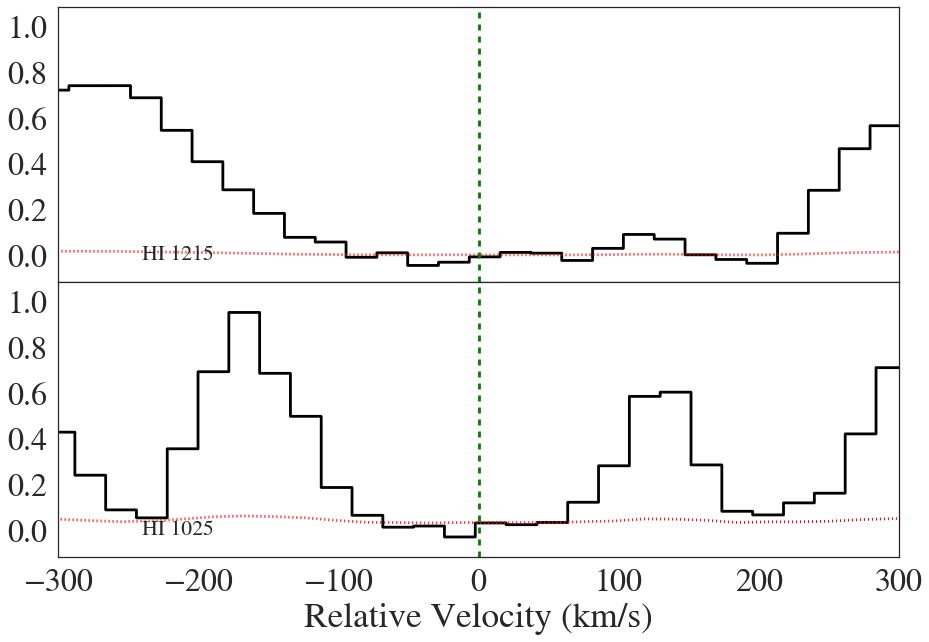

In [67]:
reload(lt_abscomp)
abscomp = lt_abscomp.AbsComponent.from_abslines([lya,lyb])
abscomp.stack_plot()